# Retail Store Markov Chains


Online/retail stores can develop a data-driven approach to product bundling, offering customers relevant bundles that align with their purchasing patterns. This not only increases the likelihood of additional sales but also enhances the overall customer experience by providing tailored product recommendations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse

In [2]:
pwd

'/mnt/vocwork4/work/eee_W_2330767/asn1944139_48/asn1944140_1/work'

### 1. Dataset
“The Instacart Online Grocery Shopping Dataset 2017”, Accessed from https://www.instacart.com/datasets/grocery-shopping-2017 on 12/3/2023.

The dataset “The Instacart Online Grocery Shopping Dataset 2017” is an anonymized dataset contains over 3 million grocery orders from more than 200,000 Instacart users.
For each user, Instacart provided between 4 and 100 of their orders, with the sequence of products purchased in each order. However, given the restriction of the assignment of 10MB. I have shrinked and modified the size of the dataset.

   Below are the variables of interest:
    
    order_id: order identifier
    product_id: product identifier
    add_to_cart_order: order in which each product was added to cart
    reordered: 1 if this prodcut has been ordered by this user in the past, 0 otherwise

### 1.a Dataset EDA

For this analysis I will be using 2 tables the products where we have the information of the products and the orders of products by the users.

In [3]:
products = pd.read_csv('products.csv')
products.head()

,product_id,product_name
0,1,Chocolate Sandwich Cookies
1,2,All-Seasons Salt
2,3,Robust Golden Unsweetened Oolong Tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...
4,5,Green Chile Anytime Sauce


In [4]:
order_products = pd.read_csv('order_products.csv')
order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


How many orders do we have in the dataset?

In [5]:
len(order_products['order_id'].unique())

42005

How many unique products we have in orders?

In [6]:
len(order_products['product_id'].unique())

27757

How many items are within each order?

In [7]:
order_products[['add_to_cart_order']].describe().T

,count,mean,std,min,25%,50%,75%,max
add_to_cart_order,422739.0,8.331642,7.085996,1.0,3.0,6.0,11.0,74.0


What is the order size distribution?

In [8]:
order_group = order_products.groupby('order_id')['product_id'].count().reset_index()

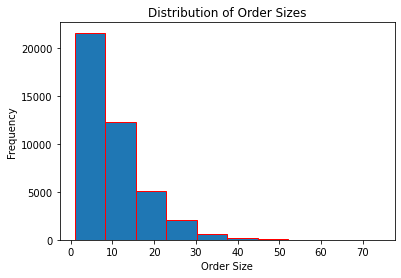

In [9]:
# Creating histogram
plt.hist(order_group['product_id'], edgecolor="red")

# Adding extra features    
plt.xlabel("Order Size")
plt.ylabel("Frequency")
plt.title('Distribution of Order Sizes')
plt.show()


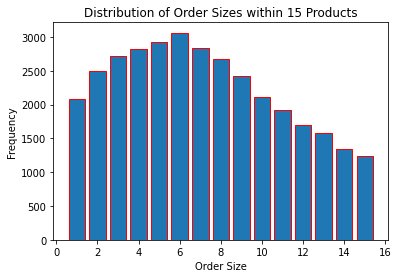

In [10]:
# Creating histogram
df_group_hist = order_group.loc[order_group['product_id']<16, 'product_id']

plt.hist(df_group_hist, bins=range(min(df_group_hist), max(df_group_hist) + 2), edgecolor="red",align='left', rwidth=0.8)

# Adding extra features    
plt.xlabel("Order Size")
plt.ylabel("Frequency")
plt.title('Distribution of Order Sizes within 15 Products')
plt.show()

From the above chart most orders are within 10 products and most of them have 6 products across all sized of checkouts

## 2. Analysis
Let's take a look at top ranked products in orders and compared them to the Markov Chain Model Rankings results

In [11]:
top_products = order_products.groupby('product_id').size().reset_index(name='count').sort_values(by= 'count', ascending = False)
top_products = top_products.merge(products, on = 'product_id', how = 'left').head(10)
top_products

,product_id,count,product_name
0,24852,6248,Banana
1,13176,5032,Bag of Organic Bananas
2,21137,3390,Organic Strawberries
3,21903,3196,Organic Baby Spinach
4,47209,2804,Organic Hass Avocado
5,47766,2283,Organic Avocado
6,47626,1972,Large Lemon
7,16797,1908,Strawberries
8,27966,1865,Organic Raspberries
9,26209,1757,Limes


### 2.a Analysis
Motivation - Banana is the top product, we will compare the above list to a new list generates by using Markov Chains based on the order patterns we observe.

1. Build Transistion Matrix
2. Evaluate Steady State of Markov Chain Model
3. Rank Products to Build bundles of products bought together

#### 1.Build Transistion Matrix
1. Create a column of the next ordered products within orders
2. Generate and add index to current products for matrix construction
3. Remove last rows of each order
4. Generate edge weights or probabilities
5. Build Sparse COO Matrix

###### 1. Create a column of the next ordered products within orders

In [12]:
# Add a new column 'Shifted_Product_ID' with the Product_ID shifted by one within each group of Order_ID
order_products_shift = order_products.copy()

order_products_shift['Shifted_Product_ID'] = order_products_shift.groupby('order_id')['product_id'].shift(-1)

#order_products_shift['Shifted_Product_ID'] = order_products_shift['Shifted_Product_ID'].astype(str)
order_products_shift.head(10)

,order_id,product_id,add_to_cart_order,reordered,Shifted_Product_ID
0,2,33120,1,1,28985.0
1,2,28985,2,1,9327.0
2,2,9327,3,0,45918.0
3,2,45918,4,1,30035.0
4,2,30035,5,0,17794.0
5,2,17794,6,1,40141.0
6,2,40141,7,1,1819.0
7,2,1819,8,1,43668.0
8,2,43668,9,0,NaN
9,3,33754,1,1,24838.0


In [13]:
# new column is float64 due to the fact we have NAN for the last products in an order like index 8
order_products_shift.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422739 entries, 0 to 422738
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   order_id            422739 non-null  int64  
 1   product_id          422739 non-null  int64  
 2   add_to_cart_order   422739 non-null  int64  
 3   reordered           422739 non-null  int64  
 4   Shifted_Product_ID  380734 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 16.1 MB


###### 2. Generate and add index to current products for matrix construction

In [14]:
products['index'] = products.index
products.head()

,product_id,product_name,index
0,1,Chocolate Sandwich Cookies,0
1,2,All-Seasons Salt,1
2,3,Robust Golden Unsweetened Oolong Tea,2
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,3
4,5,Green Chile Anytime Sauce,4


In [15]:
order_products_shift = order_products_shift.merge(products[['product_id','index']], on = 'product_id', how= 'left')
order_products_shift = order_products_shift.merge(products[['product_id','index']], left_on='Shifted_Product_ID', right_on = 'product_id', how= 'left', indicator=True)
order_products_shift.head()

,order_id,product_id_x,add_to_cart_order,reordered,Shifted_Product_ID,index_x,product_id_y,index_y,_merge
0,2,33120,1,1,28985.0,33119,28985.0,28984.0,both
1,2,28985,2,1,9327.0,28984,9327.0,9326.0,both
2,2,9327,3,0,45918.0,9326,45918.0,45917.0,both
3,2,45918,4,1,30035.0,45917,30035.0,30034.0,both
4,2,30035,5,0,17794.0,30034,17794.0,17793.0,both


In [16]:
# validate the join
order_products_shift['_merge'].value_counts(dropna=False)

both          380734
left_only      42005
right_only         0
Name: _merge, dtype: int64

Since our last product added to the cart has no transition product to go to in the network. We will remove those rows which are all the rows where they are left_only

###### 3. Remove last rows of each order

In [17]:
order_products_shift = order_products_shift[order_products_shift['_merge']!='left_only']
len(order_products_shift)

380734

In [18]:
order_products_shift

,order_id,product_id_x,add_to_cart_order,reordered,Shifted_Product_ID,index_x,product_id_y,index_y,_merge
0,2,33120,1,1,28985.0,33119,28985.0,28984.0,both
1,2,28985,2,1,9327.0,28984,9327.0,9326.0,both
2,2,9327,3,0,45918.0,9326,45918.0,45917.0,both
3,2,45918,4,1,30035.0,45917,30035.0,30034.0,both
4,2,30035,5,0,17794.0,30034,17794.0,17793.0,both
...,...,...,...,...,...,...,...,...,...
422732,44759,46654,3,1,19467.0,46653,19467.0,19466.0,both
422734,44760,37004,1,0,39130.0,37003,39130.0,39129.0,both
422735,44760,39130,2,1,35699.0,39129,35699.0,35698.0,both
422736,44760,35699,3,1,16797.0,35698,16797.0,16796.0,both


In [19]:
# Find the count of distinct product IDs across the two specified columns
n_actual = len(set(order_products_shift['product_id_x']) | set(order_products_shift['Shifted_Product_ID']))
n_actual

27704

##### 4. Generate edge weights or probabilities

In [20]:
# generates the count of all with the same initial transition
outdegrees = order_products_shift[['index_x', 'index_y']].groupby('index_x', as_index = False).count()

# renames columns and merges data into new dataframe
outdegrees.rename(columns = {'index_y' : 'OUTDEGREE'}, inplace = True)
segments = order_products_shift.merge(outdegrees, on = 'index_x', how = 'left')

# Visually inspect
segments.head(10)

,order_id,product_id_x,add_to_cart_order,reordered,Shifted_Product_ID,index_x,product_id_y,index_y,_merge,OUTDEGREE
0,2,33120,1,1,28985.0,33119,28985.0,28984.0,both,247
1,2,28985,2,1,9327.0,28984,9327.0,9326.0,both,836
2,2,9327,3,0,45918.0,9326,45918.0,45917.0,both,69
3,2,45918,4,1,30035.0,45917,30035.0,30034.0,both,9
4,2,30035,5,0,17794.0,30034,17794.0,17793.0,both,10
5,2,17794,6,1,40141.0,17793,40141.0,40140.0,both,888
6,2,40141,7,1,1819.0,40140,1819.0,1818.0,both,14
7,2,1819,8,1,43668.0,1818,43668.0,43667.0,both,26
8,3,33754,1,1,24838.0,33753,24838.0,24837.0,both,381
9,3,24838,2,1,17704.0,24837,17704.0,17703.0,both,583


In [21]:
segments['WEIGHT'] = 1.0 / segments['OUTDEGREE']
display(segments.head(10))

# These should sum to 1.0!
origin_groups = segments[['index_x', 'WEIGHT']].groupby('index_x')
assert np.allclose(origin_groups.sum(), 1.0, atol=10*n_actual*np.finfo(float).eps), "Rows of Matrix do not sum to 1.0"

,order_id,product_id_x,add_to_cart_order,reordered,Shifted_Product_ID,index_x,product_id_y,index_y,_merge,OUTDEGREE,WEIGHT
0,2,33120,1,1,28985.0,33119,28985.0,28984.0,both,247,0.004049
1,2,28985,2,1,9327.0,28984,9327.0,9326.0,both,836,0.001196
2,2,9327,3,0,45918.0,9326,45918.0,45917.0,both,69,0.014493
3,2,45918,4,1,30035.0,45917,30035.0,30034.0,both,9,0.111111
4,2,30035,5,0,17794.0,30034,17794.0,17793.0,both,10,0.100000
5,2,17794,6,1,40141.0,17793,40141.0,40140.0,both,888,0.001126
6,2,40141,7,1,1819.0,40140,1819.0,1818.0,both,14,0.071429
7,2,1819,8,1,43668.0,1818,43668.0,43667.0,both,26,0.038462
8,3,33754,1,1,24838.0,33753,24838.0,24837.0,both,381,0.002625
9,3,24838,2,1,17704.0,24837,17704.0,17703.0,both,583,0.001715


##### 5. Build Sparse COO Matrix

In [22]:
n_products = products.index.max()+1

In [23]:
# use weights as the data and the index as rows and columns with the shape of full product table in mxn
P = sp.sparse.coo_matrix((segments['WEIGHT'], (segments['index_x'], segments['index_y'])), shape = (n_products, n_products))

In [24]:
def spy(A, figsize=(20, 20), markersize=0.5):
    """Visualizes a sparse matrix."""
    fig = plt.figure(figsize=figsize)
    plt.spy(A, markersize=markersize)
    plt.show()

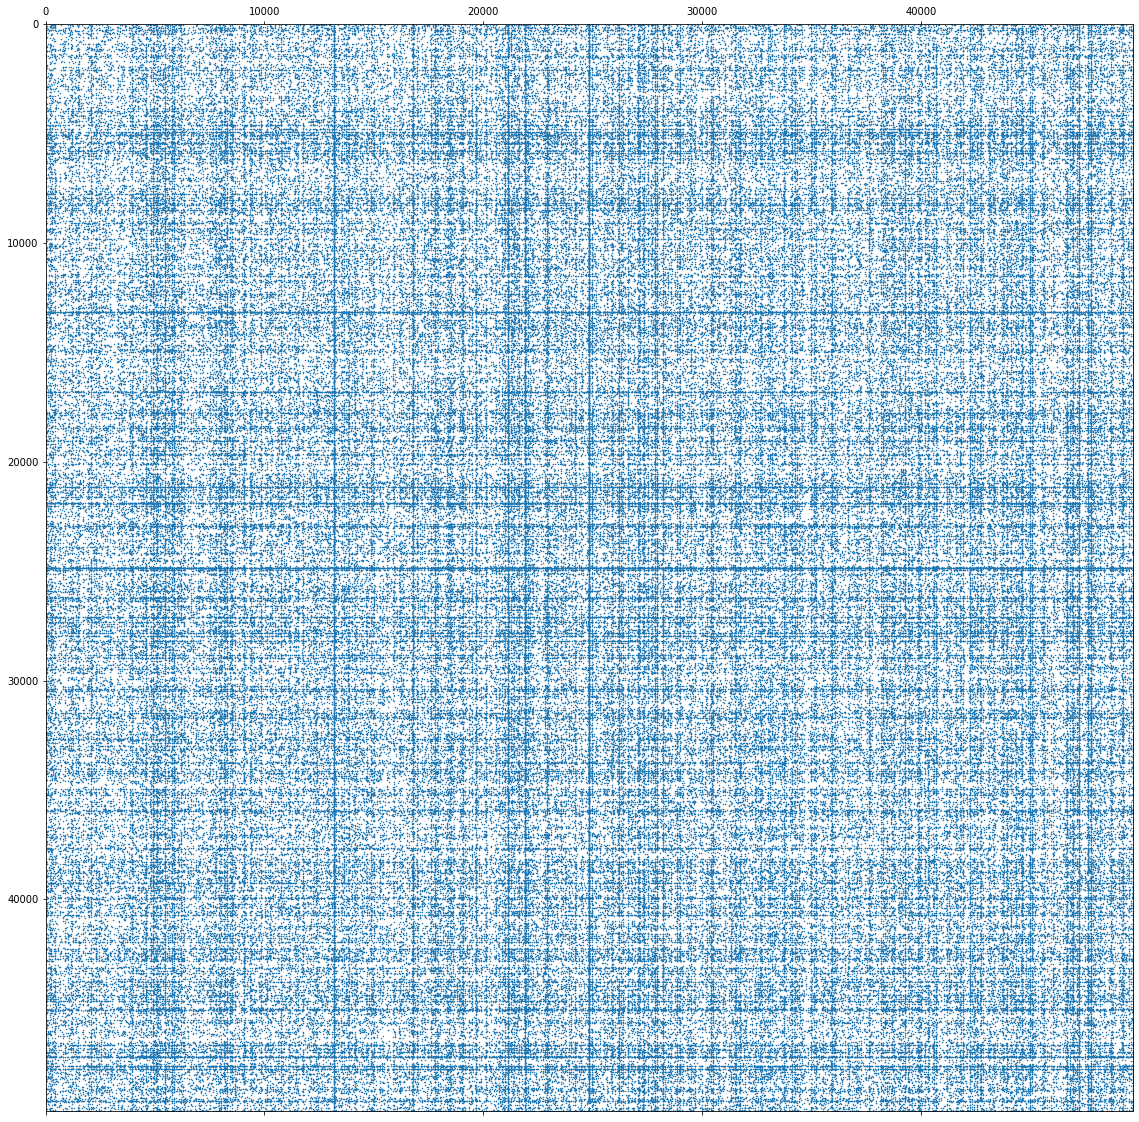

In [25]:
spy(P)

The chart shows there are many combinations of products

### 2. Build Steady State of Markov Chain Model

In [26]:
# create np array of m size
# store indexes to calculate probablility
# assign an equal probability to purchasing any product in the list

x0 = np.zeros(n_products)
actual_product_indices = segments['index_x'].unique()
x0[actual_product_indices] = 1.0 / n_products
x0

array([2.01255836e-05, 0.00000000e+00, 2.01255836e-05, ...,
       2.01255836e-05, 0.00000000e+00, 2.01255836e-05])

In [27]:
# Visually inspect your result:
def display_vec_sparsely(x, name='x'):
    i_nz = np.argwhere(x).flatten()
    df_x_nz = pd.DataFrame({'i': i_nz, '{}[i] (non-zero only)'.format(name): x[i_nz]})
    display(df_x_nz.head())
    print("...")
    display(df_x_nz.tail())
    
display_vec_sparsely(x0, name='x0')

,i,x0[i] (non-zero only)
0,0,0.00002
1,2,0.00002
2,3,0.00002
3,8,0.00002
4,9,0.00002


...


,i,x0[i] (non-zero only)
26509,49680,0.00002
26510,49682,0.00002
26511,49684,0.00002
26512,49685,0.00002
26513,49687,0.00002


In [28]:
def eval_markov_chain(P, x0, t_max):
    ###
    x = x0
    for i in range(t_max):
        x = P.T.dot(x)
    return x

In [29]:
T_MAX = 10**4
x0_copy = x0.copy()
x = eval_markov_chain(P, x0, T_MAX)

### 3. Rank Products to Build bundles of Products Bought Together

In [30]:
ranks = np.argsort(-x)

In [31]:
mc = {"index": ranks, "x(t)": x[ranks], 'rank': range(1, len(ranks)+1)}
df_mc = pd.DataFrame(mc)

In [32]:
df_mc = df_mc.merge(products, on = 'index', how ='left')

In [35]:
df_f = df_mc.merge(top_products, on = 'product_id', how ='left').head(10)
df_f.rename(columns  = {'product_name_x': 'MC_Product', 'product_name_y': 'Initial_Ranking'})

,index,x(t),rank,product_id,MC_Product,count,Initial_Ranking
0,24851,1.468858e-17,1,24852,Banana,6248.0,Banana
1,13175,1.218145e-17,2,13176,Bag of Organic Bananas,5032.0,Bag of Organic Bananas
2,21136,9.381348e-18,3,21137,Organic Strawberries,3390.0,Organic Strawberries
3,21902,8.889198e-18,4,21903,Organic Baby Spinach,3196.0,Organic Baby Spinach
4,47208,7.672367e-18,5,47209,Organic Hass Avocado,2804.0,Organic Hass Avocado
5,47765,6.117847e-18,6,47766,Organic Avocado,2283.0,Organic Avocado
6,47625,5.686006e-18,7,47626,Large Lemon,1972.0,Large Lemon
7,16796,5.181812e-18,8,16797,Strawberries,1908.0,Strawberries
8,27965,5.150916e-18,9,27966,Organic Raspberries,1865.0,Organic Raspberries
9,26208,5.073662e-18,10,26209,Limes,1757.0,Limes


## 4. Conclusion

Based on both rankings markov chains model and from the initial counts of sales they shown to be the same list. I was expecting the ranking of products to be different, however given that this is smaller dataset the results might change with the extended dataset.

Overall, with the current results I would recommend and add these 10 products some where in the view of the shopper to potentially remind them of products that customers tend to buy together.

Also, I would consider adding this products with other to increase sales.

Lastly, other areas to explore is finding the most frequent set of products bought together and finding their probability.

In [34]:
# Not-exhaustive project checklist
# Note: this is not a writing assignment, but you should still incorporate comments or headers throughout
# -- This will help others who review your work, but will also help you keep track of what you're doing
# -- Just think about what would help you understand a peer's project when you have to grade theirs later


# 1) Dataset included
# 1a) Dataset explained/documented when used
# 2) Analysis performed
# 2a) Analysis steps documented, explained briefly
# 3) Visualizations/outputs
# 4) Conclusion
# ---Did you answer your questions?
# ---Did you find anything else?
# ---What problems did you run into?
# ---Any suggestions for future research?

# Critical checks before submission
# - Does the noteboook run without error? (Kernel>restart & run all => no errors at all? No long periods of processing?)
# - Do you have your dataset included here? You shouldn't be connecting to any external data
# - - Even if external datasets work here, they WILL NOT work for peer-grading, and you may get a 0.